# 1. Import Libraries and Load Dataset

In [1]:
%%capture
#!git clone https://github.com/huggingface/transformers.git
!pip install datasets evaluate transformers[sentencepiece]
!pip install pyvi
!pip install gdown

In [2]:
#%%capture

import gdown

!gdown 1jWDnP1xF01_pmeJYsRHxSVBkLZ0I9LAt #utils T5 for VQA

Downloading...
From (original): https://drive.google.com/uc?id=1jWDnP1xF01_pmeJYsRHxSVBkLZ0I9LAt
From (redirected): https://drive.google.com/uc?id=1jWDnP1xF01_pmeJYsRHxSVBkLZ0I9LAt&confirm=t&uuid=dfb0c7c9-edfd-481b-9a19-ce44f1665398
To: /kaggle/working/utils.py
100%|████████████████████████████████████████| 109k/109k [00:00<00:00, 82.5MB/s]


In [3]:
from PIL import Image

import requests

import os
import shutil
import torch

from urllib.request import urlopen
from PIL import Image
import timm
import tqdm
import torch
from IPython.display import FileLink

In [4]:
import json

train_json = json.load(open('/kaggle/input/dsc24-vimmsd/vimmsd-train.json', encoding='utf-8'))
dev_json = json.load(open('/kaggle/input/dsc24-vimmsd/vimmsd-public-test.json', encoding='utf-8'))

# Image feature extraction

In [5]:
# images = []

# for key, item in train_json.items():
#     images.append(item['image'])

# for key, item in dev_json.items():
#     images.append(item['image'])

In [6]:
# source_all = ['/kaggle/input/dsc24-vimmsd/dev-images/dev-images',
#               '/kaggle/input/dsc24-vimmsd/train-images/train-images']

# destination = './images'
# #os.mkdir(destination)

# for source in source_all:
#     allfiles = os.listdir(source)
#     for f in allfiles:
#         src_path = os.path.join(source, f)
#         dst_path = os.path.join(destination, f)
#         shutil.copy(src_path, dst_path)

## BEiT

In [7]:
# model = timm.create_model(
#     'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
#     pretrained=True,
#     num_classes=0,  # remove classifier nn.Linear
# ).to('cuda')

# model = model.eval()
# data_config = timm.data.resolve_model_data_config(model)
# transforms = timm.data.create_transform(**data_config, is_training=False)

# img_w = {}

# def batch(iterable, n=1):
#     l = len(iterable)
#     for ndx in range(0, l, n):
#         yield iterable[ndx:min(ndx + n, l)]

In [8]:
# p = '/kaggle/working/images/'

# img_w = {}

# # get features for images, we will do this 3 images at a time to reduce time

# for x in tqdm.notebook.tqdm(batch(images, 3),total=int(len(images)/3)):
#     img = [Image.open(p + v).convert('RGB') for v in x]
#     print(x)

#     with torch.no_grad():
#         img  = torch.stack([transforms(i) for i in img]).to('cuda')
#         output = model.forward_features(img)[:,1:,:]

#     tmp_img_w = {k:v for k,v in zip(x,output)}

#     img_w.update(tmp_img_w)

#     del output
#     del tmp_img_w
#     del img
#     torch.cuda.empty_cache()

# torch.save(img_w, '/kaggle/working/beitv2-b-p.pt') # export for later used
# FileLink('/kaggle/working/beitv2-b-p.pt')

## Load extracted image features

In [9]:
import torch
from torch.nn.functional import normalize

img_w = torch.load('/kaggle/input/dsc24-vit/vit-b.pt')
# img_w = torch.load('/kaggle/input/lovecat-beitv2-b-p/beitv2-b-p.pt') # already-saved features
len(img_w)

12218

In [10]:
img_w['ac7931bb887ad853b41675f07595bf04469970d1b099ffc8806a4ceaac7d7940.jpg'].shape

torch.Size([196, 768])

# Model

In [11]:
from transformers import T5Tokenizer

from utils import T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("VietAI/vit5-base")

model = T5ForConditionalGeneration.from_pretrained("VietAI/vit5-base").to('cuda')

model.add_imgw(img_w)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at VietAI/vit5-base and are newly initialized: ['resize_img_dim.weight', 'resize_img_dim.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Prepare datasets

In [12]:
emoji_file_path = '/kaggle/input/datasets-preprocesing/emoji_to_vietnamese.json'
stopword_path = '/kaggle/input/datasets-preprocesing/vietnamese-stopwords.txt'

def load_resources(stopword_path, emoji_file_path):
    # Đọc stopword từ file txt
    with open(stopword_path, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().splitlines())

    # Đọc emoji từ file JSON
    with open(emoji_file_path, 'r', encoding='utf-8') as emoji_file:
        emoji_dict = json.load(emoji_file)

    return stopwords, emoji_dict

stopwords, emoji_dict = load_resources(stopword_path, emoji_file_path)

In [13]:
import pandas as pd

train_df = pd.DataFrame(train_json).T
test_df = pd.DataFrame(dev_json).T # public test

In [14]:
train_df['image_id'] = train_df['image'].astype(str)
test_df['image_id'] = test_df['image'].astype(str)

train_df['caption'] = train_df['caption'].astype(str)
test_df['caption'] = test_df['caption'].astype(str)

train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

train_df.drop(columns=['image'], inplace=True)
test_df.drop(columns=['image'], inplace=True)

train_df.head()

,caption,label,image_id
0,Cô ấy trên mạng vs cô ấy ngoài đời =))),multi-sarcasm,8ae451edcd8ebf697f8763ece249115813149c55733bf8...
1,Người tâm linh giao tiếp với người thực tế :))),not-sarcasm,35370ffd6c791d6f8c4ab3dd4363ed468fab41e4824ee9...
2,Hình như Trăng hôm nay đẹp quá mọi người ạ! 😃 ...,multi-sarcasm,316fdd1477725b9fb1a55015ac06b68b92b50bd4303e08...
3,MỌI NGƯỜI NGHĨ SAO VỀ PHÁT BIỂU CỦA SHARK VIỆT...,not-sarcasm,8a0f34e0e30e4e5cfb306933c1d25fa801a5da78646b59...
4,2 tay hai nàng chứ việc gì phải lệ hai hàng,multi-sarcasm,e517a5e95d1065886a7c815e82fe254381d4f9f4b244d4...


### Features enrichment

In [15]:
!gdown 1q7_-PEQQ6IR3Ortz45vEiSiOnweRJ40H # cap train
!gdown 1wldmw8IJgX-nK2_yfo8fLx55KfWGIZhp # cap dev 

Downloading...
From: https://drive.google.com/uc?id=1q7_-PEQQ6IR3Ortz45vEiSiOnweRJ40H
To: /kaggle/working/vi_train_captions.json
100%|███████████████████████████████████████| 11.3M/11.3M [00:00<00:00, 170MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wldmw8IJgX-nK2_yfo8fLx55KfWGIZhp
To: /kaggle/working/vi_dev_captions.json
100%|███████████████████████████████████████| 1.14M/1.14M [00:00<00:00, 111MB/s]


In [16]:
!gdown 1AnM0RUMfyGYWaiUgafufEKMjB8zo5dUt # object reg train
!gdown 1sk2vJutRJLCUwQ6ZKJQeYFKpvdkjUiBs # object reg dev

Downloading...
From: https://drive.google.com/uc?id=1AnM0RUMfyGYWaiUgafufEKMjB8zo5dUt
To: /kaggle/working/objects-recognition-train.json
100%|███████████████████████████████████████| 2.49M/2.49M [00:00<00:00, 184MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sk2vJutRJLCUwQ6ZKJQeYFKpvdkjUiBs
To: /kaggle/working/objects-recognition-dev.json
100%|█████████████████████████████████████████| 317k/317k [00:00<00:00, 107MB/s]


In [17]:
!gdown 1nh3y-lXq2CEc_rwzeTqGIU69VZA4eVEn # OCR dev
!gdown 1YSn-dWwprc0nhOgRUIj5aFPaW9lxKWZT

Downloading...
From: https://drive.google.com/uc?id=1nh3y-lXq2CEc_rwzeTqGIU69VZA4eVEn
To: /kaggle/working/ocr-results-dev.json
100%|█████████████████████████████████████████| 669k/669k [00:00<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YSn-dWwprc0nhOgRUIj5aFPaW9lxKWZT
To: /kaggle/working/ocr-results-train.json
100%|███████████████████████████████████████| 4.06M/4.06M [00:00<00:00, 183MB/s]


In [18]:

# Open JSON files with utf-8 encoding to handle non-ASCII characters
with open('/kaggle/working/vi_train_captions.json', encoding='utf-8') as f:
    cap_train = json.load(f)

with open('/kaggle/working/vi_dev_captions.json', encoding='utf-8') as f:
    cap_test = json.load(f)

with open('/kaggle/working/objects-recognition-train.json', encoding='utf-8') as f:
    obj_train = json.load(f)

with open('/kaggle/working/objects-recognition-dev.json', encoding='utf-8') as f:
    obj_test = json.load(f)

with open('/kaggle/working/ocr-results-dev.json', encoding='utf-8') as f:
    ocr_test = json.load(f)

with open('/kaggle/working/ocr-results-train.json', encoding='utf-8') as f:
    ocr_train = json.load(f)

In [19]:
def json_to_df(json):
    df = pd.DataFrame(json)
    df['image_id'] = df['image'].astype(str)
    df.drop(columns=['image'], inplace=True)

    return df

In [20]:
for item in ocr_train:
    item["OCR"] = ", ".join(item["OCR"])
for item in ocr_test:
    item["OCR"] = ", ".join(item["OCR"])

In [21]:
cap_test_df = json_to_df(cap_test)

cap_train_df = json_to_df(cap_train)

obj_train_df = json_to_df(obj_train)

obj_test_df = json_to_df(obj_test)

ocr_train_df = json_to_df(ocr_train)

ocr_test_df = json_to_df(ocr_test)

In [22]:
obj_train_df['object_recognition'] = obj_train_df['object_recognition'].apply(lambda x: "Trong hình có " + x + ". " if len(x) > 0 else "")
obj_test_df['object_recognition'] = obj_test_df['object_recognition'].apply(lambda x: "Trong hình có " + x + ". " if len(x) > 0 else "")
obj_test_df.head()

,object_recognition,image_id
0,"Trong hình có người, đồ vật, phim hoạt hình, đ...",2d06d8c77c741d001916199346cc112847e6bcf61b3dce...
1,"Trong hình có truyện, người, dải, phim hoạt hì...",c981f23fc77cebd06ea872ea2c0ff6ec43a9d2517366ed...
2,"Trong hình có số, ghi, chữ.",342c9a8f91adeacde0f2c26dee3e6b86861b43e948d10b...
3,"Trong hình có diều, người, văn bản.",2aa95c65c0a6444caff0657ed21e27fbc403af1727749a...
4,"Trong hình có suv, xe thể, quảng cáo, xe hơi, ...",9d6ebb26087b8d6051f77ef7cbf3e9a0d750baa41b45d7...


In [23]:
ocr_train_df['OCR'] = ocr_train_df['OCR'].apply(lambda row: "Chữ trong hình là " + row + ". " if len(row) > 0 else "")
ocr_test_df['OCR'] = ocr_test_df['OCR'].apply(lambda row: "Chữ trong hình là " + row + ". " if len(row) > 0 else "")

# cap_train_df['caption'] = cap_train_df['caption'].apply(lambda row: row[:150] if len(row) > 150 else row)
# cap_test_df['caption'] = cap_test_df['caption'].apply(lambda row: row[:150] if len(row) > 150 else row)

In [24]:
def enrich(df1, df2, add_field):
    temp = df2.set_index('image_id')
    
    df1['caption'] = df1.apply(
        lambda row: row['caption'] + ' ' + temp.loc[row['image_id'], add_field]
        if row['image_id'] in temp.index else row['caption'], axis=1
    )

    return df1


In [25]:
train_df['caption'] = train_df['caption'].apply(lambda x: x[:150] if len(x) > 150 else x)
test_df['caption'] = test_df['caption'].apply(lambda x: x[:150] if len(x) > 150 else x)

train_df = enrich(train_df, ocr_train_df, 'OCR')
test_df = enrich(test_df, ocr_test_df, 'OCR')

train_df = enrich(train_df, cap_train_df, 'caption')
test_df = enrich(test_df, cap_test_df, 'caption')

# train_df = enrich(train_df, obj_train_df, 'object_recognition')
# test_df = enrich(test_df, obj_test_df, 'object_recognition')

In [26]:
train_df.head()

,caption,label,image_id
0,Cô ấy trên mạng vs cô ấy ngoài đời =))) Bức ả...,multi-sarcasm,8ae451edcd8ebf697f8763ece249115813149c55733bf8...
1,Người tâm linh giao tiếp với người thực tế :))...,not-sarcasm,35370ffd6c791d6f8c4ab3dd4363ed468fab41e4824ee9...
2,Hình như Trăng hôm nay đẹp quá mọi người ạ! 😃 ...,multi-sarcasm,316fdd1477725b9fb1a55015ac06b68b92b50bd4303e08...
3,MỌI NGƯỜI NGHĨ SAO VỀ PHÁT BIỂU CỦA SHARK VIỆT...,not-sarcasm,8a0f34e0e30e4e5cfb306933c1d25fa801a5da78646b59...
4,2 tay hai nàng chứ việc gì phải lệ hai hàng H...,multi-sarcasm,e517a5e95d1065886a7c815e82fe254381d4f9f4b244d4...


### Text preprocessing

In [27]:
import re
def preprocess_text(text):
    def remove_stopwords(text):
        return text
    def replace_emojis(text):
        for emoji, description in emoji_dict.get('emoji', {}).items():
            text = text.replace(emoji, description)  # Thay thế emoji bằng mô tả
        return text

    def replace_emoticons(text):
        for emoticon, meaning in emoji_dict.get('biểu_tượng', {}).items():
            emoticon_pattern = re.escape(emoticon) + r"{1,}"
            text = re.sub(emoticon_pattern, meaning, text)
        return text

    def normalize_text(text):
        text = text.lower()  # Chuyển thành chữ thường
        text = re.sub(r'(?<=\w)[\/\.\-\_,\\](?=\w)', '', text)  # Loại bỏ dấu chấm hoặc gạch nối trong từ
        return text

    text = replace_emojis(text)       # Thay thế emoji
    text = replace_emoticons(text)    # Thay thế biểu cảm
    text = normalize_text(text)       # Chuẩn hóa văn bản
    text = remove_stopwords(text)
    return text

In [28]:
train_df['caption'] = train_df['caption'].astype(str)
test_df['caption'] = test_df['caption'].astype(str)

In [29]:
train_df['caption'] = train_df['caption'].apply(preprocess_text)
test_df['caption'] = test_df['caption'].apply(preprocess_text)

In [30]:
train_df['caption'].iloc[2003]

'may mà gặp được tôi chữ trong hình là trờl olll_, làm sao thế này?!?, cậu bạn này đang vẽ dở, thỉ lăn đùng ra (o giật, sùl bọt mép!, nguy quá!, để tôl glúp!, 1.  hình ảnh mô tả một dải truyện tranh có một nhân vật hoạt hình và một người đang vẽ trên giá vẽ. nhân vật hoạt hình đang cầm một cây cọ vẽ trên một tay và một cây cọ trên tay kia, trong khi người đó đang ngồi trên giá vẽ với nụ cười trên môi. nội dung của hình ảnh có thể mang tính châm biếm, vì người đó đang cố gắng trêu chọc nỗ lực vẽ của người khác. tuy nhiên, nó cũng có thể mang tính giải trí, vì người đó dường như đang có một khoảng thời gian vui vẻ khi vẽ trên giá vẽ. nhìn chung, nội dung của hình ảnh có thể được coi là châm biếm hoặc giải trí, tùy thuộc vào quan điểm của người đó.'

In [31]:
import pandas as pd

from sklearn.model_selection import train_test_split

X = train_df.drop(columns=['label'])  # Features
y = train_df['label']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_test, y_test], axis=1)

In [32]:
print(train_df.shape, val_df.shape, test_df.shape)

(9724, 3) (1081, 3) (1413, 3)


### Convert to Dataset

In [33]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, TrainingArguments, Seq2SeqTrainingArguments
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["inputs"], max_length=400, truncation=True, padding=True
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["labels"], max_length=32, truncation=True, padding=True
        )
    model_inputs['labels'] = labels['input_ids']
    model_inputs['input_ids'] = model_inputs['input_ids']
    model_inputs["image_id"] = examples["image_id"]
    
    return model_inputs

In [34]:
dict_obj = {}

dict_obj['inputs'] = train_df['caption'].astype(str).tolist()  # Convert Series to list
dict_obj['labels'] = train_df['label'].astype(str).tolist()    # Convert Series to list
dict_obj['image_id'] = train_df['image_id'].astype(str).tolist()
train_dataset = Dataset.from_dict(dict_obj)
tokenized_train_datasets = train_dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=8)

dict_obj = {}
dict_obj['inputs'] = val_df['caption'].astype(str).tolist()  # Convert Series to list
dict_obj['labels'] = val_df['label'].astype(str).tolist()    # Convert Series to list
dict_obj['image_id'] = val_df['image_id'].astype(str).tolist()
val_dataset = Dataset.from_dict(dict_obj)
tokenized_val_datasets = val_dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=8)


#0:   0%|          | 0/2 [00:00<?, ?ba/s]

#1:   0%|          | 0/2 [00:00<?, ?ba/s]

#2:   0%|          | 0/2 [00:00<?, ?ba/s]

#3:   0%|          | 0/2 [00:00<?, ?ba/s]

#4:   0%|          | 0/2 [00:00<?, ?ba/s]

#5:   0%|          | 0/2 [00:00<?, ?ba/s]

#6:   0%|          | 0/2 [00:00<?, ?ba/s]

#7:   0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

#5:   0%|          | 0/1 [00:00<?, ?ba/s]

#4:   0%|          | 0/1 [00:00<?, ?ba/s]

#6:   0%|          | 0/1 [00:00<?, ?ba/s]

#7:   0%|          | 0/1 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

# Train

In [35]:
import random

import numpy as np

import torch

def set_SEED():
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [36]:
import os
from transformers.optimization import Adafactor, AdafactorSchedule
from transformers import DataCollatorForSeq2Seq
from utils import DataCollatorForSeq2Seq

os.environ["WANDB_DISABLED"] = "True"
set_SEED()

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

#Adam
training_args = Seq2SeqTrainingArguments(output_dir="./checkpoint",
                                      do_train=True,
                                      do_eval=True,
                                      num_train_epochs=2,
                                      learning_rate=2.5e-5,
                                      warmup_ratio=0.05,
                                      weight_decay=0.01,
                                      per_device_train_batch_size=8,
                                      per_device_eval_batch_size=8,
                                      logging_dir='./log',
                                      group_by_length=True,
                                      save_strategy="steps",
                                      evaluation_strategy="steps",
                                      save_total_limit=5,
                                      eval_steps=100,
                                      logging_steps = 100,
                                      save_steps=100,
                                      load_best_model_at_end= True,
                                      fp16=True,
                                      seed=42,
                                      )

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [37]:
tokenized_train_datasets

Dataset({
    features: ['labels', 'image_id', 'input_ids', 'attention_mask'],
    num_rows: 9724
})

In [38]:
tokenized_val_datasets

Dataset({
    features: ['labels', 'image_id', 'input_ids', 'attention_mask'],
    num_rows: 1081
})

In [39]:
trainer = Seq2SeqTrainer(
    model = model,
    args = training_args,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_val_datasets,
    data_collator=data_collator,
)

trainer.train()

Step,Training Loss,Validation Loss
100,6.119200,0.193678
200,0.165800,0.129950
300,0.147700,0.124674
400,0.135100,0.141539
500,0.129800,0.109040
600,0.116300,0.111312
700,0.114900,0.107218
800,0.123300,0.120326
900,0.115600,0.103290
1000,0.113800,0.112908


TrainOutput(global_step=2432, training_loss=0.35625073637225124, metrics={'train_runtime': 1875.9361, 'train_samples_per_second': 10.367, 'train_steps_per_second': 1.296, 'total_flos': 9289096667136000.0, 'train_loss': 0.35625073637225124, 'epoch': 2.0})

In [40]:
import matplotlib.pyplot as plt
import json

# save loss
log_history = {'log_history':trainer.state.log_history}

with open('logs.json', 'w', encoding='utf-8') as f:
    json.dump(log_history, f, ensure_ascii=False, indent=4)

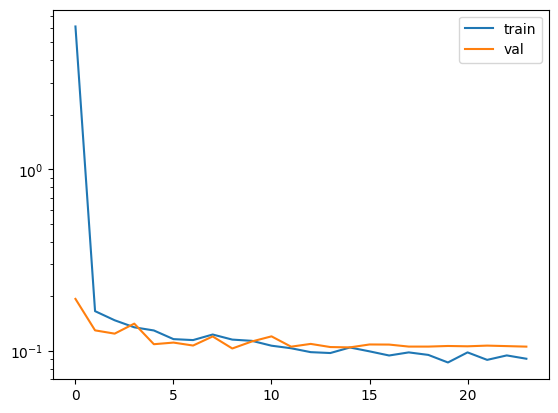

In [41]:
from matplotlib import pyplot

train_loss = {i['step']:i['loss'] for i in log_history['log_history'] if 'loss' in i.keys()}
eval_loss = {i['step']:i['eval_loss'] for i in log_history['log_history'] if 'eval_loss' in i.keys()}
plt.plot(list(train_loss.values()))
plt.plot(list(eval_loss.values()))

plt.yscale('log')
plt.legend(['train','val'])

# Load checkpoints and predict



In [71]:
torch.cuda.empty_cache()
model = T5ForConditionalGeneration.from_pretrained("/kaggle/working/checkpoint/checkpoint-2200")
model.to('cuda')
model.add_imgw(img_w)

In [72]:
from datasets import Dataset

dict_obj = {}
dict_obj['inputs'] = test_df['caption']
dict_obj['labels'] =  test_df['label']
dict_obj['image_id'] = test_df['image_id']
test_dataset = Dataset.from_dict(dict_obj)
tokenized_test_datasets = test_dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=8)

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

#4:   0%|          | 0/1 [00:00<?, ?ba/s]

#5:   0%|          | 0/1 [00:00<?, ?ba/s]

#6:   0%|          | 0/1 [00:00<?, ?ba/s]

#7:   0%|          | 0/1 [00:00<?, ?ba/s]

In [73]:
import gc
torch.cuda.empty_cache()
gc.collect()

34

In [74]:
tokenized_test_datasets

Dataset({
    features: ['labels', 'image_id', 'input_ids', 'attention_mask'],
    num_rows: 1413
})

In [75]:
import torch 
import numpy as np
from datasets import load_metric
metrics = load_metric('accuracy')

torch.cuda.empty_cache()
max_target_length = 10
dataloader = torch.utils.data.DataLoader(tokenized_test_datasets, collate_fn=data_collator, batch_size=4) #replace tokenized_dev_datasets with tokenized_test_datasets

predictions = []
references = []

for i, batch in enumerate(tqdm(dataloader)):
    # greedy search
    outputs = model.generate(image_id = batch['image_id'],
        input_ids=batch['input_ids'].to('cuda'),
        max_length=max_target_length,
        attention_mask=batch['attention_mask'].to('cuda'),
        return_dict_in_generate=True, output_attentions=True,)

    #beam search for now   
    # outputs = model.generate(
    #     image_id = np.repeat(batch['image_id'], 7),
    #     input_ids=batch['input_ids'].to('cuda'),
    #     max_length=max_target_length,
    #     attention_mask=batch['attention_mask'].to('cuda'),
    #     return_dict_in_generate=True, output_attentions=True,
    #     num_beams=7,
    #     no_repeat_ngram_size=2)
    
    with tokenizer.as_target_tokenizer():
        outputs = [tokenizer.decode(out, clean_up_tokenization_spaces=False, skip_special_tokens=True) for out in outputs.sequences]
        labels = np.where(batch['labels'] != -100,  batch['labels'], tokenizer.pad_token_id)
        # actuals = [tokenizer.decode(out, clean_up_tokenization_spaces=False, skip_special_tokens=True) for out in labels]

    predictions.extend(outputs)


  0%|          | 0/354 [00:00<?, ?it/s]

In [76]:
len(predictions)

1413

In [77]:
def postprocessing(t):
    t = t.lower()
    t = t.replace('\\','')
    return t

test_predicted = {k:postprocessing(i) for k,i in zip(dev_json.keys(),predictions)}

In [78]:
result_json = {
    "results": test_predicted,
    "phase": "dev"
}

In [79]:

with open('results.json', 'w') as fp:
    json.dump(result_json, fp,ensure_ascii=True,indent=True)

# Finetune for classification task